### EXP: Full launch2 QC rating 

- **Aim:** First full launch of quality control (QC) of brain registration on the Zooniverse platform. Raters are some of zooniverse users ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 100 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 and COBRE datsets.
    - We asked raters on the Zooniverse platform to QC images based on the tutorial and the rated sample images.

In [1]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

In [3]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [4]:
# Read raw table
classifications = pd.read_csv('../data/rating/start-project-2-classifications_28-01-2019.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [5]:
# List all workflows 
classifications.workflow_name.unique()

array(['Start Project 2'], dtype=object)

In [6]:
# Filter out only specific workflow
ratings = classifications.loc[classifications['workflow_name'].isin(['Start Project 2'])]
ratings.count()

classification_id    5367
user_name            5367
user_id              3926
user_ip              5367
workflow_id          5367
workflow_name        5367
workflow_version     5367
created_at           5367
gold_standard           0
expert                  0
metadata             5367
annotations          5367
subject_data         5367
subject_ids          5367
dtype: int64

In [7]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in ratings.annotations]

# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]

# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]

# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['image1'] for ind,row in ratings.iterrows()]


In [223]:
# Extract two expert raters ('colezweber','ppf') and save them for after  
#expert_ = ratings[ratings.user_name.isin([ 'colezweber','ppf','jenichen'])]
# Save to csv
##expert_.to_csv('../data/rating/Full_launch1_ppf-colezweber.csv',index=False)

In [224]:
# Remove 3 experts and one outlier
#ratings = ratings[~ratings.user_name.isin(['jenichen','colezweber','ppf','willy71'])]

In [8]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count.head()

IsabellaGalli7322    174
mulke102             167
ashherr17            151
IaLaVyu              144
Vayla                114
Name: user_name, dtype: int64

In [9]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=20]
user_count[list_user]

IsabellaGalli7322                     174
mulke102                              167
ashherr17                             151
IaLaVyu                               144
Vayla                                 114
cecora                                110
Uganalandia                           102
loretadoga                             99
darbystevens                           99
thisguyiknow                           71
not-logged-in-c61c0ef44c2772f737e0     69
john.rielley                           61
oldduck                                57
paule00                                55
SAPfeiffer                             55
MMilhollen                             54
AdamMorse                              52
not-logged-in-ca15cae9f889311d70d7     51
S4R4H                                  50
ttli                                   50
zhilly8                                48
EloiPrevost                            47
ajay_patel                             46
roberto099                        

In [10]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    3247
user_name            3247
user_id              2721
user_ip              3247
workflow_id          3247
workflow_name        3247
workflow_version     3247
created_at           3247
gold_standard           0
expert                  0
metadata             3247
annotations          3247
subject_data         3247
subject_ids          3247
n_tagging            3247
rating               3247
ID                   3247
imgnm                3247
dtype: int64

In [11]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

not-logged-in-1e9cae3af501218aeb4b have 5 duplicated ratings
MMilhollen have 1 duplicated ratings
evajensen have 1 duplicated ratings
ashherr17 have 5 duplicated ratings
not-logged-in-3cead6b3eac102808e30 have 1 duplicated ratings
erika.long have 7 duplicated ratings
mulke102 have 21 duplicated ratings
not-logged-in-98da46eebbbc09974522 have 3 duplicated ratings
AliKhatibi have 1 duplicated ratings
IaLaVyu have 6 duplicated ratings
IsabellaGalli7322 have 38 duplicated ratings
not-logged-in-7060aa62b234ec484300 have 4 duplicated ratings
not-logged-in-ca15cae9f889311d70d7 have 8 duplicated ratings
not-logged-in-5d07536ec65f2b99ab6a have 2 duplicated ratings
not-logged-in-c61c0ef44c2772f737e0 have 11 duplicated ratings
20090057 have 4 duplicated ratings
not-logged-in-152d7db26b2e1a24da73 have 5 duplicated ratings
S4R4H have 39 duplicated ratings
not-logged-in-8d3e22f1bb9331e1e13d have 8 duplicated ratings
iwantaburger have 19 duplicated ratings
Ebeths2018 have 15 duplicated ratings
not-lo

In [12]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

ashherr17                             146
mulke102                              146
IaLaVyu                               138
IsabellaGalli7322                     136
Vayla                                 114
Uganalandia                           102
loretadoga                             99
darbystevens                           99
thisguyiknow                           71
not-logged-in-c61c0ef44c2772f737e0     58
oldduck                                57
SAPfeiffer                             55
MMilhollen                             53
EloiPrevost                            47
roberto099                             46
not-logged-in-ca15cae9f889311d70d7     43
not-logged-in-5d07536ec65f2b99ab6a     39
melika.kh                              38
not-logged-in-98da46eebbbc09974522     35
Kwpow                                  34
Littledutchie                          34
not-logged-in-7060aa62b234ec484300     33
ngallant                               32
20090057                          

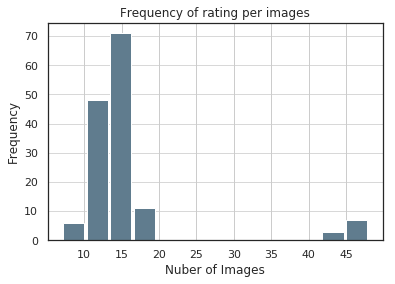

In [13]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [14]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,ashherr17,mulke102,IaLaVyu,IsabellaGalli7322,Vayla,Uganalandia,loretadoga,darbystevens,thisguyiknow,...,john.rielley,not-logged-in-8d304b26ec52167d8419,ajay_patel,not-logged-in-f7e5dd44ee73ffca044f,mgreenidge,ttli,Amandonlon,AdamMorse,zhilly8,juliahoffman
0,HC0040024,OK,OK,Maybe,OK,OK,OK,NaN,OK,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HC0040048,OK,OK,OK,OK,OK,OK,OK,OK,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HC0040057,OK,OK,Maybe,OK,OK,OK,Fail,NaN,OK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HC0040086,OK,Maybe,Fail,OK,Fail,OK,OK,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SZ0040002,OK,OK,OK,OK,OK,OK,Maybe,OK,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [16]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,HC0040024,0,3,9
1,HC0040048,2,1,8
2,HC0040057,2,2,11
3,HC0040086,5,5,6
4,SZ0040002,0,3,12


In [17]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,HC0040024,0,0.25,0.75,0.750000,OK
1,HC0040048,0.181818,0.0909091,0.727273,0.727273,OK
2,HC0040057,0.133333,0.133333,0.733333,0.733333,OK
3,HC0040086,0.3125,0.3125,0.375,0.375000,OK
4,SZ0040002,0,0.2,0.8,0.800000,OK


Text(0, 0.5, 'Concensus rating')

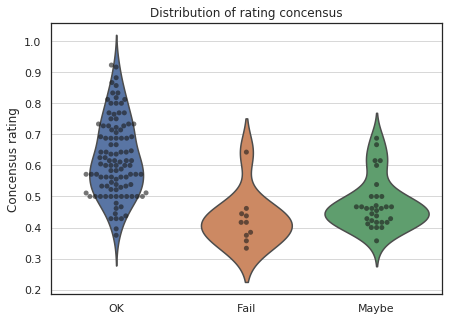

In [18]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')

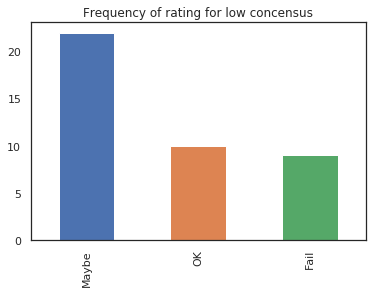

In [19]:
count_ = df_norm.concensus_NoExp[[0 <= row.max_value_NoExp < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

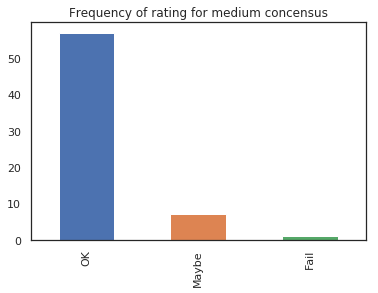

In [20]:
count_ = df_norm.concensus_NoExp[[0.5 <= row.max_value_NoExp < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

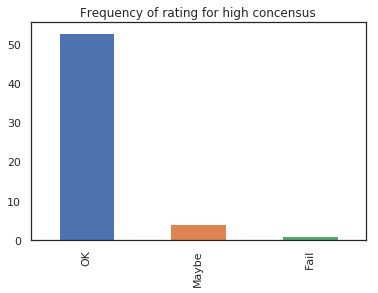

In [21]:
count_ = df_norm.concensus_NoExp[[0.6 < row.max_value_NoExp <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

In [33]:
# Save a copy of concensus
df_norm[['ID','concensus_NoExp']].rename(columns={'concensus_NoExp':'Zcon'}).to_csv('../data/rating/full_launch2_zooniverse_consensus.csv',index=False)

In [42]:
df_norm[df_norm['concensus_NoExp'] == 'Maybe']

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
8,SZ0040098,0.0666667,0.466667,0.466667,0.466667,Maybe
14,HC0040068,0.0666667,0.466667,0.466667,0.466667,Maybe
21,HC0040067,0.0909091,0.454545,0.454545,0.454545,Maybe
22,HC0040026,0.153846,0.461538,0.384615,0.461538,Maybe
26,HC0040144,0.2,0.466667,0.333333,0.466667,Maybe
28,SZ0040039,0.133333,0.6,0.266667,0.600000,Maybe
30,SZ0040100,0.176471,0.411765,0.411765,0.411765,Maybe
33,HC0040038,0.0833333,0.5,0.416667,0.500000,Maybe
35,SZ0040028,0.214286,0.5,0.285714,0.500000,Maybe
38,SZ0040046,0.142857,0.428571,0.428571,0.428571,Maybe


### Report tagging from Full lanch 2 raters

In [35]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.user_name.replace({'simexp':'PB','Yassinebha':'YB'},inplace=True)
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,HC0040027,Start Project 2,not-logged-in-1e9cae3af501218aeb4b,Maybe,57.96875,102.0,1.5,4,HC0040027_anat.png,0
1,HC0040027,Start Project 2,not-logged-in-1e9cae3af501218aeb4b,Maybe,56.96875,309.0,1.5,4,HC0040027_anat.png,0
2,HC0040027,Start Project 2,not-logged-in-1e9cae3af501218aeb4b,Maybe,278.96875,345.0,1.5,4,HC0040027_anat.png,0
3,HC0040027,Start Project 2,not-logged-in-1e9cae3af501218aeb4b,Maybe,281.96875,599.0,1.5,4,HC0040027_anat.png,0
4,HC0040033,Start Project 2,not-logged-in-1e9cae3af501218aeb4b,OK,330.96875,286.0,1.5,3,HC0040033_anat.png,0


In [36]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm.head()

,ID,imgnm
0,HC0040013,HC0040013_anat.png
1,HC0040014,HC0040014_anat.png
2,HC0040017,HC0040017_anat.png
3,HC0040018,HC0040018_anat.png
4,HC0040019,HC0040019_anat.png


In [37]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [38]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

### Plot heat map for all tagging

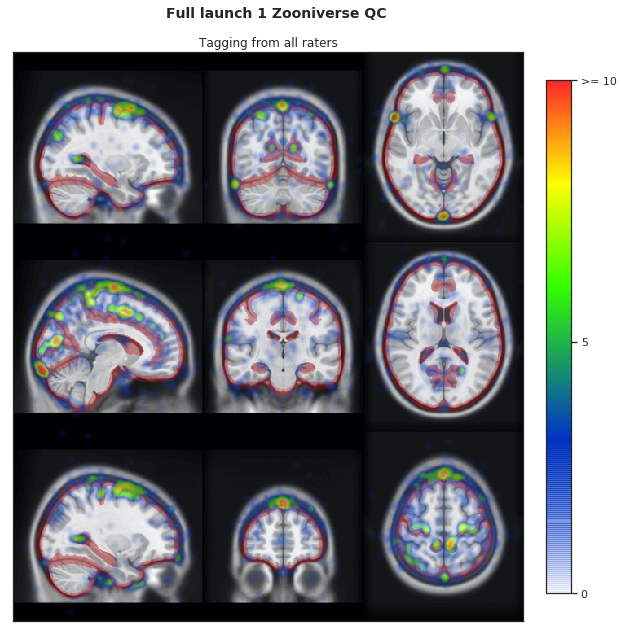

In [40]:
from heatmappy import Heatmapper
from PIL import Image

patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v4.png')
axes.set_title('Tagging from all raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=15,
                        point_strength = 0.1,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '>= 10'])

img.close()
heatmap.close()
#f.savefig('../reports/figures/Full_launch1_qc_heatmap_tags.svg')

### Compare kappa within non-expert from full launch 1

In [122]:
# How many rating per user
user_count = classi_unique.user_name.value_counts()
user_count

rubyadeline                           100
1010101                               100
Uganalandia                           100
sueburr                               100
MsImmortal                            100
RLINDS4026                            100
lobusparietalis                       100
hallkr                                 98
narguedasn                             95
juliejo                                87
ashherr17                              76
kitchenmi                              68
alinanaseer                            64
ChaoticK                               54
Michaelspili                           54
alyssalewis4                           49
Dillen                                 48
AlyPereira21                           44
AndrejGalinac                          44
1a2r3u4n                               43
Hmelting                               41
sanitha.yang                           39
Service55                              39
not-logged-in-4d11726c1f714afe8e57

In [123]:
# Select only raters how completed 100 images
list_user = user_count.index
list_user = list_user[user_count.values==100]
user_count[list_user]

rubyadeline        100
1010101            100
Uganalandia        100
sueburr            100
MsImmortal         100
RLINDS4026         100
lobusparietalis    100
Name: user_name, dtype: int64

In [124]:
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings_F1 = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating).apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_ratings_F1.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
df_ratings_F1.head()

,ID,rubyadeline,1010101,Uganalandia,sueburr,MsImmortal,RLINDS4026,lobusparietalis
0,X3912996,2,1,2,2,2,2,1
1,X0023019,1,1,2,2,2,2,2
2,X0021014,3,3,1,3,3,3,3
3,HC0040053,2,1,2,1,2,3,1
4,X1038415,1,3,1,2,2,3,1


In [125]:
# Percenteage of agrrement between raters with R package IRR
agree_ = df_ratings_F1.drop(columns='ID',axis=1)
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 100 
   Raters = 7 
  %-agree = 12 



In [126]:
# Get Kappa score out of all different combination of ratings
kappa_df  = df_ratings_F1.drop(columns='ID',axis=1)
kappa_df.rename(columns={'1010101':'X1010101'},inplace=True)
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.29 , std : 0.08

 Fleiss' Kappa for m Raters

 Subjects = 100 
   Raters = 7 
    Kappa = 0.195 

        z = 12.5 
  p-value = 0 



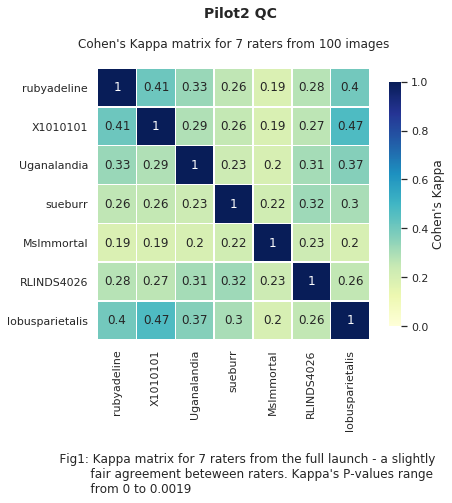

In [127]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for 7 raters from {} images".format(len(df_ratings)),pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters from the full launch - a slightly 
            fair agreement beteween raters. Kappa's P-values range 
            from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(.1,-0.3,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/full_launch1_qc.svg')

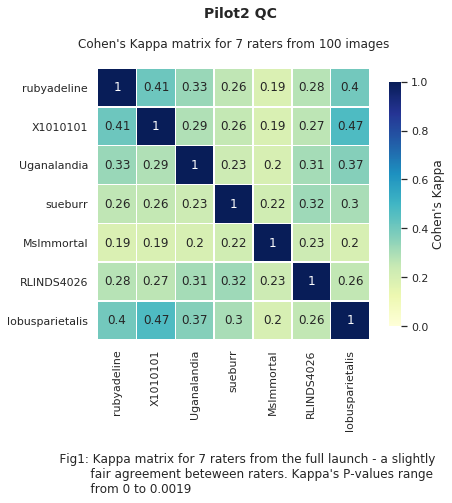

In [128]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot2 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for 7 raters from {} images".format(len(df_ratings)),pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters from the full launch - a slightly 
            fair agreement beteween raters. Kappa's P-values range 
            from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(.1,-0.3,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/full_launch1_qc.svg')